# 2. Digits Classification with K Nearest Neighbors (40 points)

## Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt

## Appendix: Python Tips

### Loading and Visualizing MNIST-5-6-Subset Data

In [15]:
# Load the data from MNIST-5-6-Subset.txt
# Change the path as needed
data_file_path = "data/MNIST-5-6-Subset.txt"
data_matrix = np.loadtxt(data_file_path).reshape(1877, 784)
# Load the labels from MNIST-5-6-Labels.txt
# Change the path as needed
labels_file_path = "data/MNIST-5-6-Subset-Labels.txt"
labels = np.loadtxt(labels_file_path)

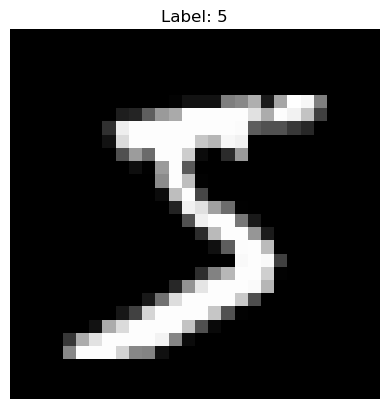

In [16]:
# Assuming you want to visualize the first image
# Change the index as needed
image_index = 0
image_data = data_matrix[image_index]
selected_label = int(labels[image_index])
# Visualize the image using Matplotlib
# We transpose the image to make the number look upright.
plt.imshow(image_data.reshape(28,28).transpose(1,0), cmap='gray')
plt.title(f"Label: {selected_label}")
plt.axis('off') # Turn off axis
plt.show()

### Setting up a figure with axis labels, legend and title

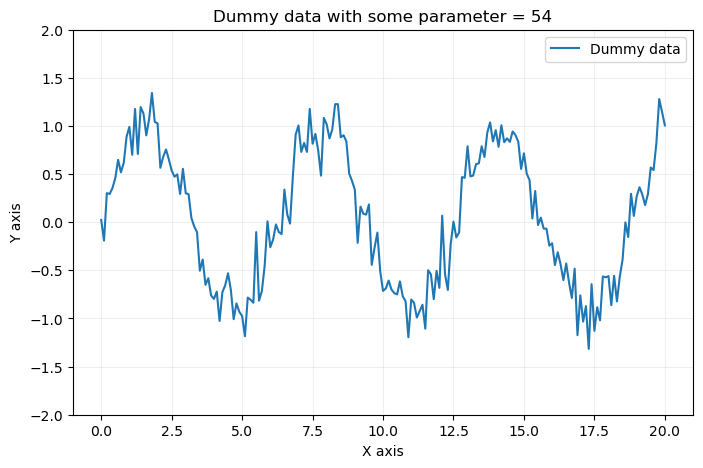

In [17]:
# Dummy data, x and y
x = np.arange(0, 20.1, 0.1)
y = np.sin(x) + np.random.normal(0, 0.2, len(x))
some_parameter = 54
# Initialise figure (fig) and axis (ax)
fig, ax = plt.subplots(figsize=(8,5))
# Plot in axis, add label to data
ax.plot(x, y, label='Dummy data') # (*)
# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title(f'Dummy data with some parameter = {some_parameter}')
# Add grid
ax.grid(alpha=0.2)
# Set axes limits
ax.set_ylim(-2,2)
# Add legend (remember to label the data as shown above (*))
ax.legend()
# Show plot
plt.show()
# Save plot to some local path
#fig.savefig('output/validation_err.png')

### Using vector operations with Numpy

In [18]:
# Say we have a data matrix with dimension (50, 10)
data_matrix = np.random.rand(50, 10)
print('data_matrix shape:', data_matrix.shape)
# .. and we want to subtract from all of its columns a vector of dimension (10)
some_vector = np.random.rand(10)
print('some_vector shape:', some_vector.shape)
# Instead of looping through the data matrix and subtracting like so,
result_loop = np.zeros_like(data_matrix)
for i,column in enumerate(data_matrix):
    result_loop[i] = column - some_vector
print('result_loop shape:', result_loop.shape)
# We can use vector operations to greatly improve the speed,
# at which we achieve the same result.
# The essential action involves expanding the dimensions of "some_vector",
# aligning it with the dimensions of
# the "data_matrix." np.newaxis␣ accomplishes this by encapsulating
# the original data with ":", while simultaneously creating a new dimension.
some_vector_new = some_vector[np.newaxis, :]
print('some_vector shape after expansion:', some_vector_new.shape)
# Now we can subtract some_vector simply like this
result_vector = data_matrix - some_vector_new
print('result_vector shape:', result_vector.shape)
# Assert that the two results are equal
print('result_loop == result_vector:', np.all(result_loop == result_vector))
# We can easily check how large of a speedup we achieve by using the time package
from time import time
loop_time = []
vector_time = []
for _ in range(250):
    # For loop
    t = time()
    for i,column in enumerate(data_matrix):
        result_loop[i] = column - some_vector
    loop_time.append(t - time())
    # Vector operation
    t = time()
    result_vector = data_matrix - some_vector[np.newaxis, :]
    vector_time.append(t - time())

print(f'Speed up: {(np.mean(loop_time) / np.mean(vector_time)):1.3f}')

data_matrix shape: (50, 10)
some_vector shape: (10,)
result_loop shape: (50, 10)
some_vector shape after expansion: (1, 10)
result_vector shape: (50, 10)
result_loop == result_vector: True
Speed up: -inf


C:\Users\hdc\AppData\Local\Temp\ipykernel_15772\3127147266.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'Speed up: {(np.mean(loop_time) / np.mean(vector_time)):1.3f}')


### Other useful Numpy functions: cumsum, sort and argsort

In [19]:
# Creating an example array
data = np.array([5, 2, 8, 1, 6])
# 1)
# Calculating cumulative sum using cumsum
cumulative_sum = np.cumsum(data)
print("Original data:", data)
print("Cumulative sum:", cumulative_sum)
# Documentation for np.cumsum: https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
# 2)
# Sorting the array using sort
sorted_data = np.sort(data)
print("\nOriginal data:", data)
print("Sorted data:", sorted_data)
# Documentation for np.sort: https://numpy.org/doc/stable/reference/generated/numpy.sort.html
# 3)
# Getting indices that would sort the array using argsort
sorted_indices = np.argsort(data)
print("\nOriginal data:", data)
print("Sorted indices:", sorted_indices)
# Documentation for np.argsort: https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
# 4)
# Accessing elements in sorted order using sorted indices
sorted_data_using_indices = data[sorted_indices]
print("\nOriginal data:", data)
print("Sorted data using indices:", sorted_data_using_indices)

Original data: [5 2 8 1 6]
Cumulative sum: [ 5  7 15 16 22]

Original data: [5 2 8 1 6]
Sorted data: [1 2 5 6 8]

Original data: [5 2 8 1 6]
Sorted indices: [3 1 0 4 2]

Original data: [5 2 8 1 6]
Sorted data using indices: [1 2 5 6 8]


## Task #1

### Load data

In [20]:
# Load data
data_file_path = "data/MNIST-5-6-Subset.txt"
labels_file_path = "data/MNIST-5-6-Subset-Labels.txt"
data_matrix = np.loadtxt(data_file_path).reshape(1877, 784)
labels = np.loadtxt(labels_file_path)

# Convert labels from {5, 6} to {-1, 1}
labels = np.where(labels == 5, -1, 1)

### Define training set

In [21]:
m = 50

training_points = data_matrix[:m]
training_labels = labels[:m]

### Function knn

In [22]:
# See Algorithm 1 on page 6 in [YS]
def knn(training_points, training_labels, test_point, test_label):   
    # 2. Calculate pairwise distances (d_i = d(x_i, x)) between test point and training points using euclidean distance.
    distances = np.sum(np.square((training_points - test_point)), axis=1)
    # using np.linalg.norm
    #distances = np.linalg.norm(training_points - test_point, axis=1)
    
    # 3. Sort distances (d_i's) in ascending order and get corresponding indices
    distances_sorted_indices = np.argsort(distances)
    
    # 4. Calculate the summed up sign of the labels of the K nearest neighbors,
    # by summing the labels (majority vote) of the K nearest neighbors and taking the sign of the sum.
    ys = np.sign(np.cumsum(training_labels[distances_sorted_indices]))

    # If there is a voting tie, only look at the K-1 neighbors
    for i in range(len(ys)):
        if ys[i] == 0:
            ys[i] = ys[i-1]

    errors = np.where(ys != test_label, 1, 0)

    return errors

### Validation error & Variance

In [23]:
num_validation_sets = 5
K = range(1, m + 1)

In [24]:
def do_validation(data_matrix: np.ndarray, n_values: list):
    
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    
    for n in n_values:
        fig2, ax2 = plt.subplots(figsize=(8, 5))

        mean_validation_errors_all = []
        
        for i in range(num_validation_sets):
            # Define validation set
            start_idx = m + i * n
            end_idx = m + (i + 1) * n
            
            validation_points = data_matrix[start_idx:end_idx]
            validation_labels = labels[start_idx:end_idx]

            # Calculate validation error
            validation_errors_for_set = np.zeros(m)
            
            for val_point, val_label in zip(validation_points, validation_labels):
                validation_error = knn(training_points, training_labels, val_point, val_label)
                validation_errors_for_set += validation_error
            
            # Divide by n to get the average error for each K
            mean_validation_errors_for_set = validation_errors_for_set / n

            ax2.plot(K, mean_validation_errors_for_set, label=f'Validation set {i+1}')

            # Calculate variance of validation error for comparing validation sets
            mean_validation_errors_all.append(mean_validation_errors_for_set)
        
        # Plot the mean validation error as a function of K
        ax2.set_xlabel('K')
        ax2.set_ylabel('Validation error')
        ax2.set_title(f'Validation error for K=(1,...,{m}), m={m}, n={n}')
        ax2.grid(alpha=0.2)
        ax2.legend()

        # Stack the validation errors for each set, so that we can calculate the variance
        mean_validation_errors_stacked_for_each_set = np.vstack(mean_validation_errors_all)
        variance_of_sets = np.var(mean_validation_errors_stacked_for_each_set, axis=0)
        
        # Plot the variance of the validation error as a function of K
        ax1.plot(K, variance_of_sets, label=f'n = {n}')
        ax1.set_xlabel('K')
        ax1.set_ylabel('Variance of validation error')
        ax1.set_title(f'Variance of validation error for K=(1,...,{m}), m={m}')
        ax1.grid(alpha=0.2)
        ax1.legend()
        
    plt.show()

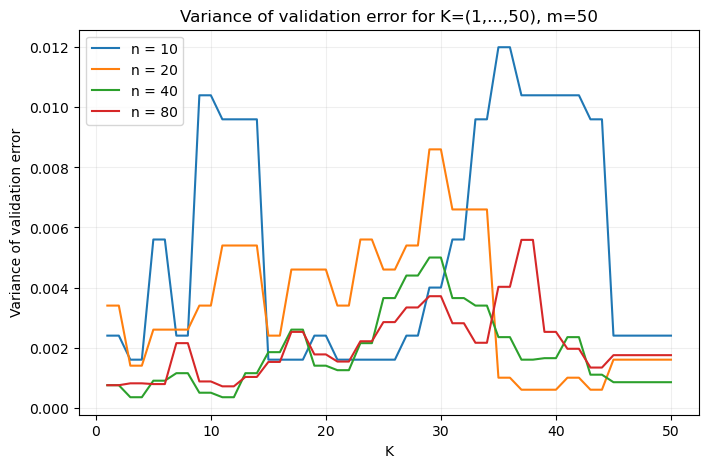

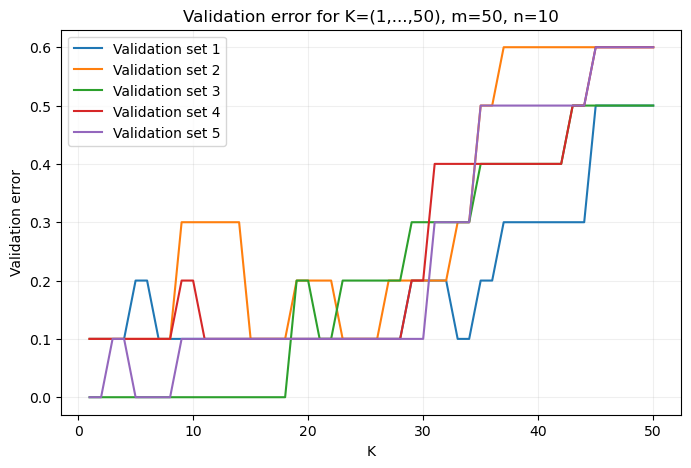

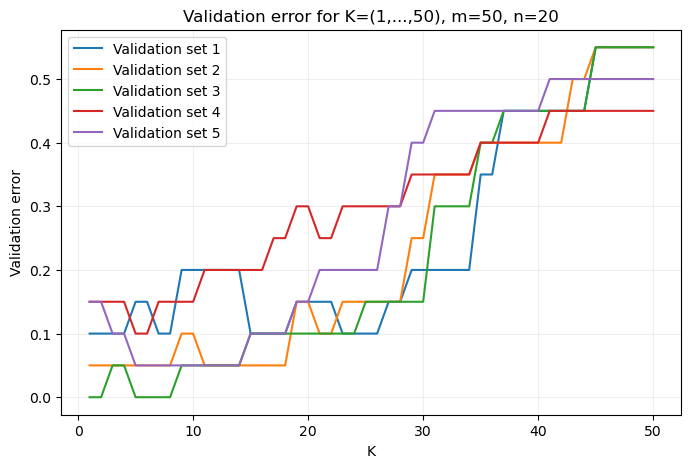

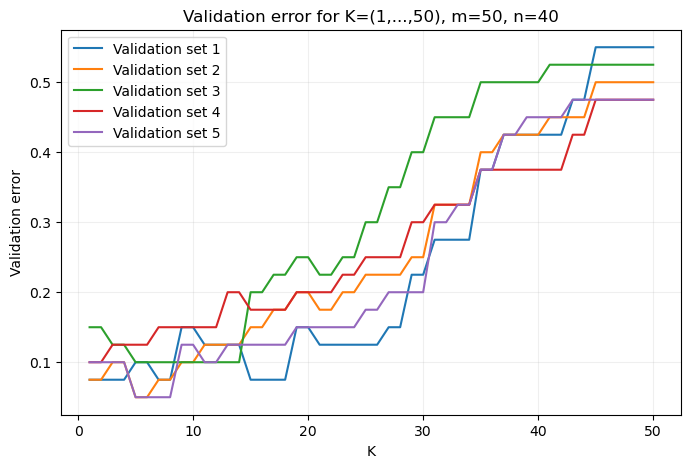

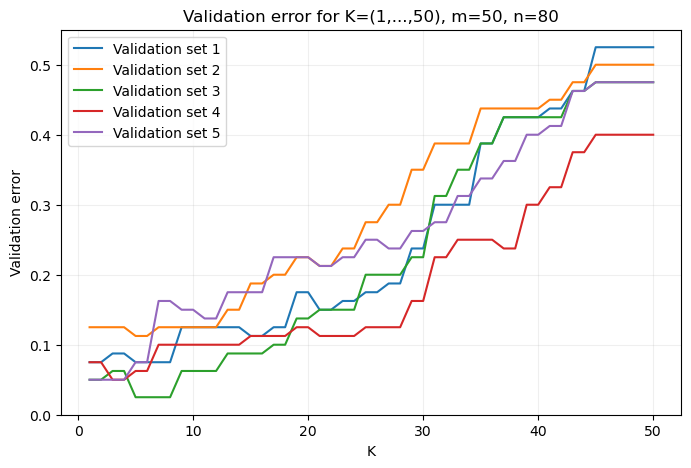

In [25]:
n_values = [10, 20, 40, 80]  # Size of validation set

do_validation(data_matrix, n_values)

## Task #2: Choosing the optimal k

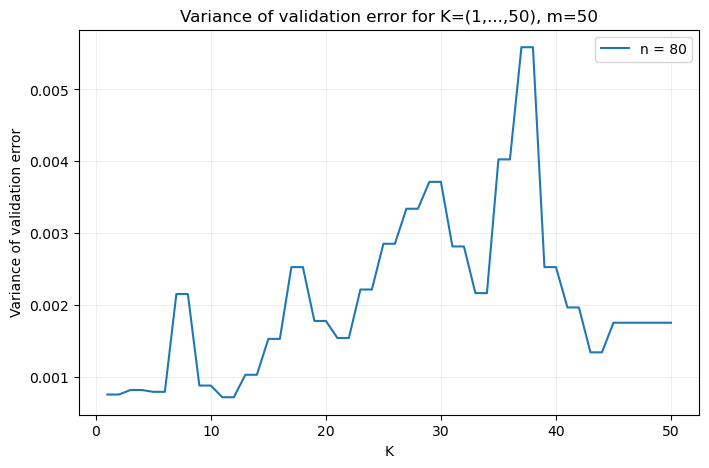

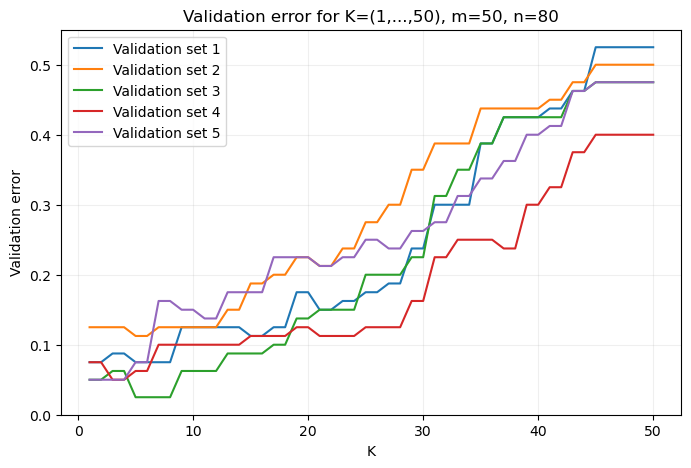

In [27]:
n_values = [80]

do_validation(data_matrix, n_values)

### Light-Corruption set

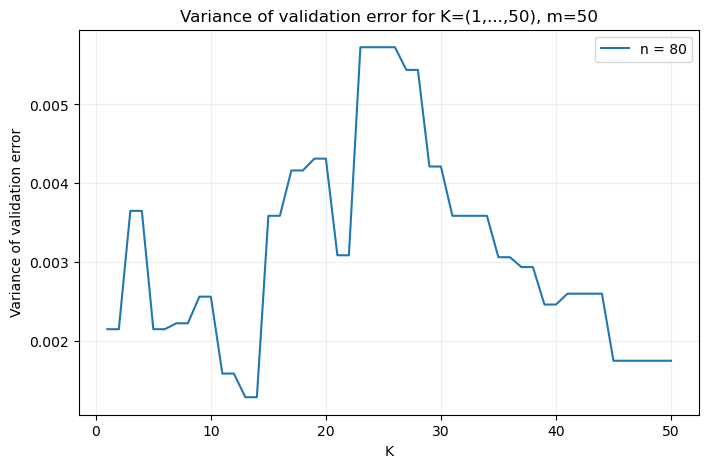

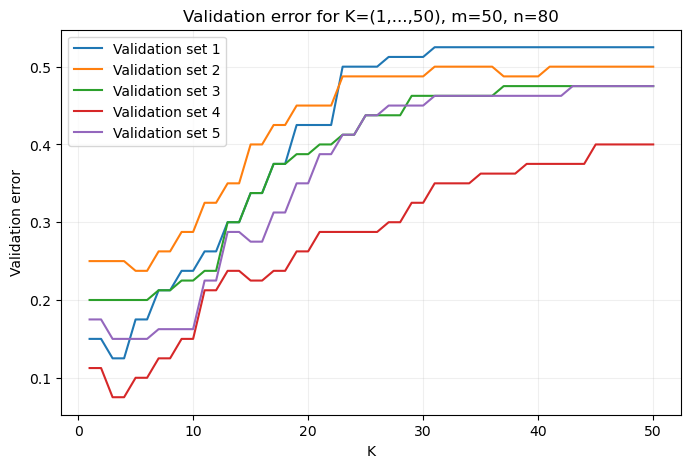

In [28]:
data_file_path_light_corruption = "data/MNIST-5-6-Subset-Light-Corruption.txt"
data_matrix2 = np.loadtxt(data_file_path_light_corruption).reshape(1877, 784)

n_values = [80]

do_validation(data_matrix2, n_values)

### Moderate-Corruption set

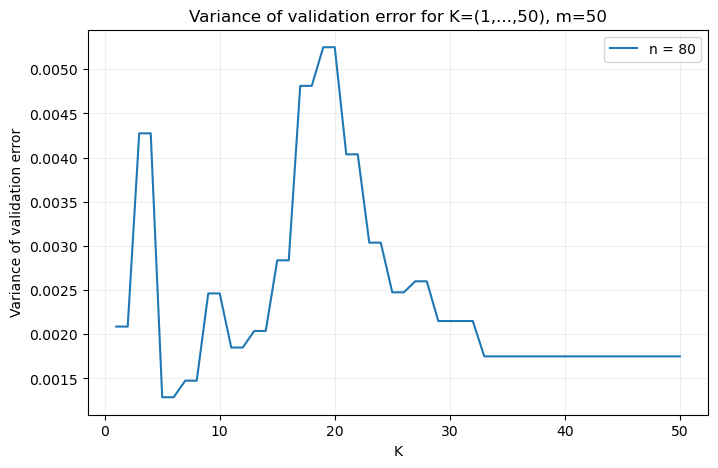

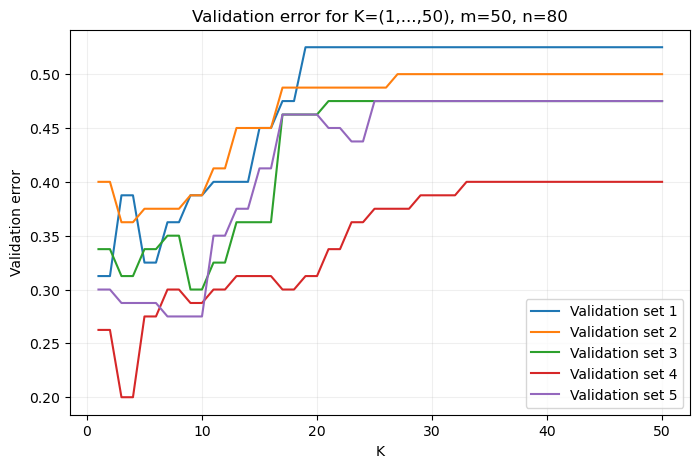

In [29]:
data_file_path_light_corruption = "data/MNIST-5-6-Subset-Moderate-Corruption.txt"
data_matrix3 = np.loadtxt(data_file_path_light_corruption).reshape(1877, 784)

n_values = [80]

do_validation(data_matrix3, n_values)

### Heavy-Corruption set

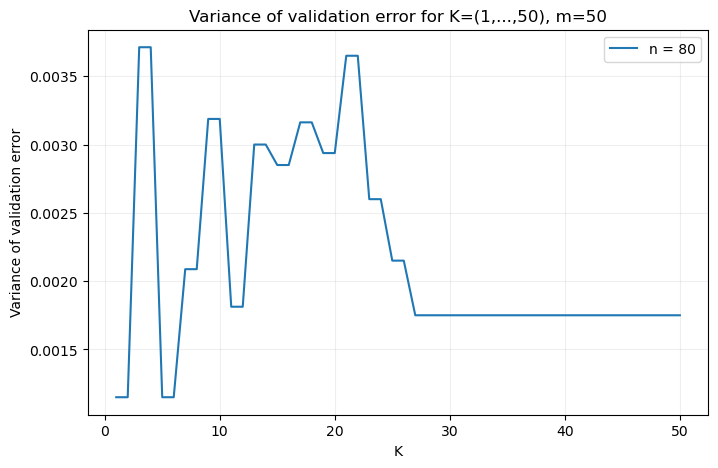

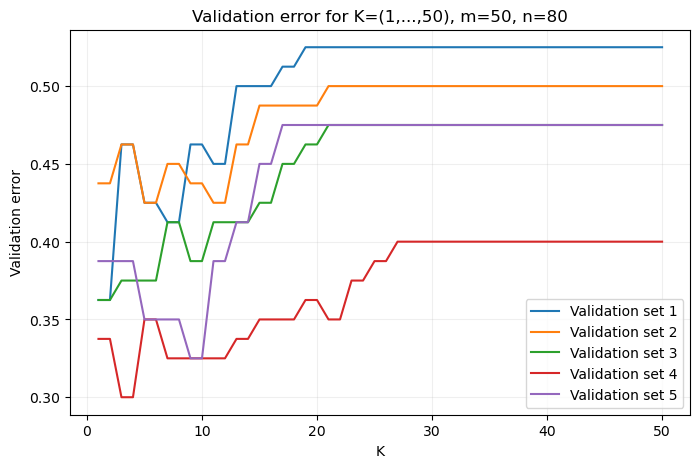

In [30]:
data_file_path_light_corruption = "data/MNIST-5-6-Subset-Heavy-Corruption.txt"
data_matrix4 = np.loadtxt(data_file_path_light_corruption).reshape(1877, 784)

n_values = [80]

do_validation(data_matrix4, n_values)